## Transfer_Learning

## Imports 

In [1]:
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as Layers

In [2]:
foldernames = os.listdir('../data/images/keggle_data_animals/raw-img')
category_names = []
categories = []
files = []
i = 0
for k, folder in enumerate(foldernames):
    filenames = os.listdir("../data/images/keggle_data_animals/raw-img/" + folder);
    for file in filenames:
        files.append("../data/images/keggle_data_animals/raw-img/" + folder + "/" + file)
        categories.append(k)
        category_names.append(folder)
        
df = pd.DataFrame({
    'filename': files,
    'category': categories,
    'category_names': category_names
})
train_df = pd.DataFrame(columns=['filename', 'category'])
for i in range(10):
    train_df = train_df.append(df[df.category == i])

train_df.head()
train_df = train_df.reset_index(drop=True)
train_df

,filename,category,category_names
0,../data/images/keggle_data_animals/raw-img/but...,0,butterfly
1,../data/images/keggle_data_animals/raw-img/but...,0,butterfly
2,../data/images/keggle_data_animals/raw-img/but...,0,butterfly
3,../data/images/keggle_data_animals/raw-img/but...,0,butterfly
4,../data/images/keggle_data_animals/raw-img/but...,0,butterfly
...,...,...,...
26174,../data/images/keggle_data_animals/raw-img/squ...,9,squirrel
26175,../data/images/keggle_data_animals/raw-img/squ...,9,squirrel
26176,../data/images/keggle_data_animals/raw-img/squ...,9,squirrel
26177,../data/images/keggle_data_animals/raw-img/squ...,9,squirrel


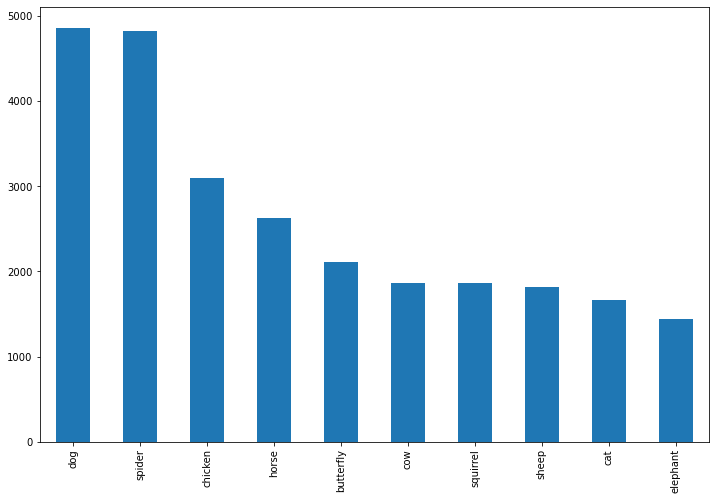

In [3]:
plt.figure(figsize=(12,8))
train_df["category_names"].value_counts().plot.bar();

In [4]:
def shapes_distr(filename,size):
    W = []
    H = []
    for i in tqdm(range(size)):
        indx = np.random.choice(len(filename))
        id_ = filename[indx]
        img = plt.imread(id_)
        H.append(img.shape[0])
        W.append(img.shape[1])
    return W,H

In [5]:
W,H = shapes_distr(train_df['filename'],1000)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 250.33it/s]


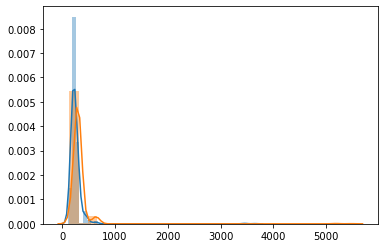

In [6]:
sns.distplot(H)
sns.distplot(W);

## Hyparams

In [7]:
VAL_SIZE = 0.25
IMAGE_WIDTH, IMAGE_HEIGHT = 224,224
IMAGE_CHANNELS = 3
IMG_SIZE = (IMAGE_WIDTH,IMAGE_HEIGHT)
RANDOM_STATE = 5
TRAIN_BATCH_SIZE = 16
VAL_BATCH_SIZE = 16
EPOCHS = 10

## Train Test split

In [8]:
train_DF,val_DF = train_test_split(train_df,test_size = VAL_SIZE,random_state = RANDOM_STATE) #keep seed for random

In [9]:
print(train_DF.shape[0])
print(val_DF.shape[0])

19634
6545


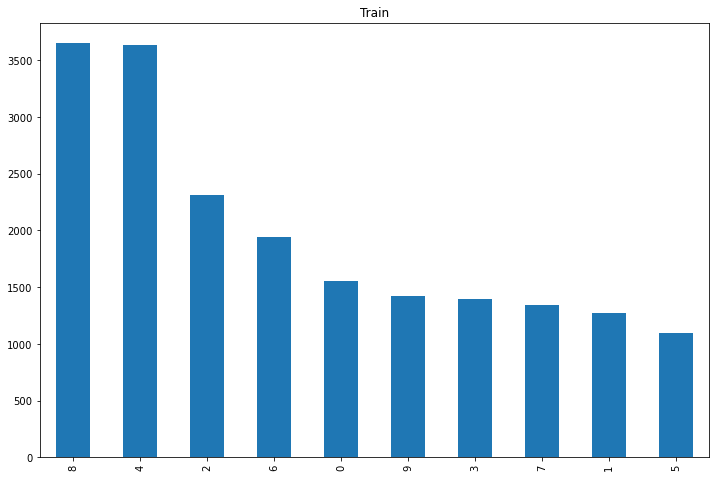

In [10]:
plt.figure(figsize=(12,8))
train_DF["category"].value_counts().plot.bar()
plt.title("Train");

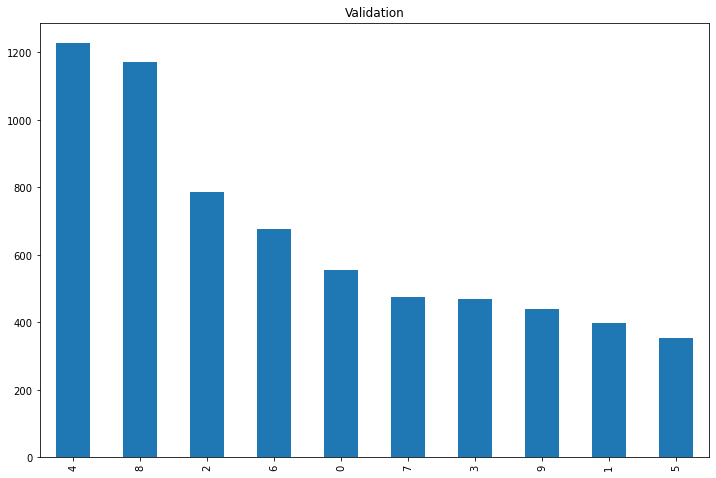

In [11]:
plt.figure(figsize=(12,8))
val_DF["category"].value_counts().plot.bar()
plt.title("Validation");

## Datagenerators 

In [12]:
train_DF.head()

,filename,category,category_names
24561,../data/images/keggle_data_animals/raw-img/squ...,9,squirrel
16401,../data/images/keggle_data_animals/raw-img/hor...,6,horse
20148,../data/images/keggle_data_animals/raw-img/spi...,8,spider
19948,../data/images/keggle_data_animals/raw-img/spi...,8,spider
2551,../data/images/keggle_data_animals/raw-img/cat...,1,cat


In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=15,
    brightness_range = [0.6,1.0],
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_DF,  
    x_col='filename',
    y_col='category_names',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=TRAIN_BATCH_SIZE
)

Found 19634 validated image filenames belonging to 10 classes.


In [15]:
train_batch,train_labels = next(train_generator)

In [16]:
def plot_batch(batch,labels):
    for i in range(batch.shape[0]):
        img,label = batch[i],labels[i]
        plt.imshow(img)
        plt.show()

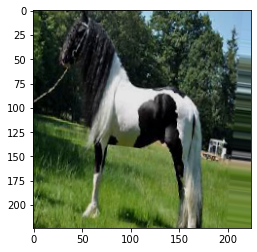

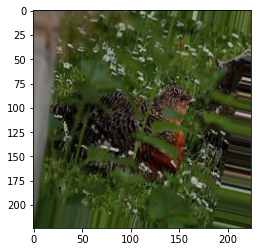

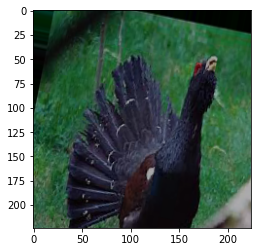

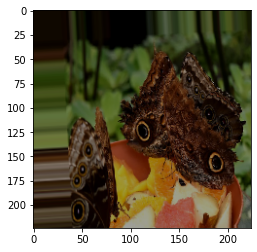

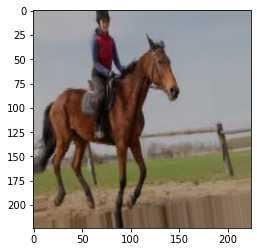

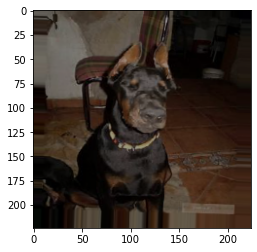

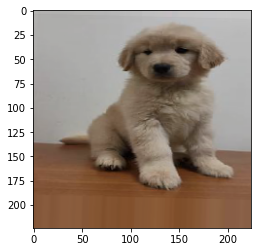

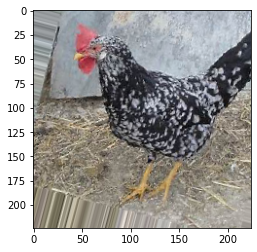

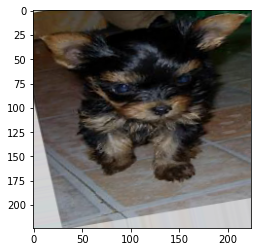

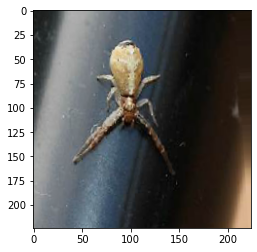

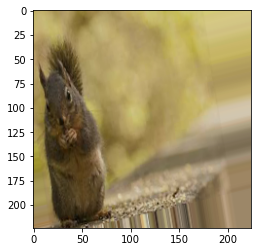

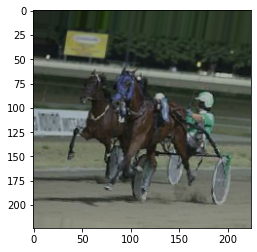

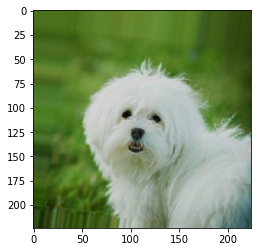

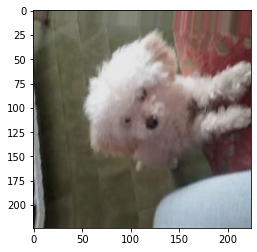

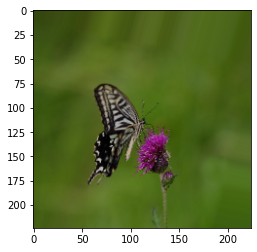

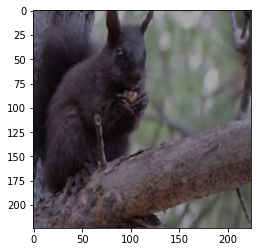

In [17]:
plot_batch(train_batch,train_labels)

In [19]:
val_datagen = ImageDataGenerator(
    rescale=1./255,
)

val_generator = val_datagen.flow_from_dataframe(
    val_DF, 
    x_col='filename',
    y_col='category_names',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=VAL_BATCH_SIZE
)

Found 6545 validated image filenames belonging to 10 classes.


In [20]:
val_batch,val_lables = next(val_generator)

def plot_batch(batch,labels):
    for i in range(batch.shape[0]):
        img,label = batch[i],labels[i]
        plt.imshow(img)
        plt.show()

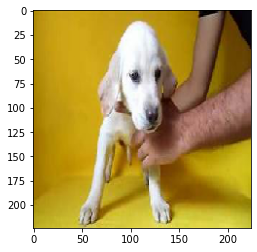

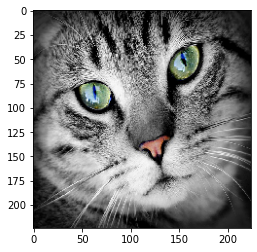

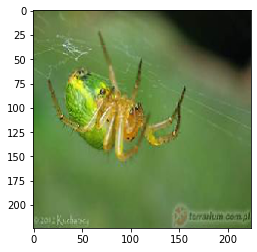

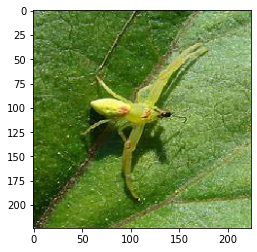

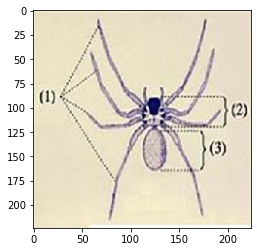

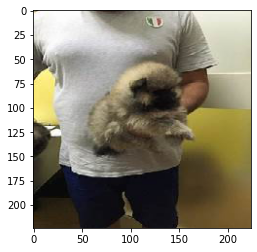

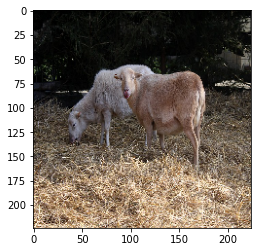

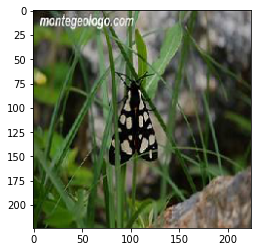

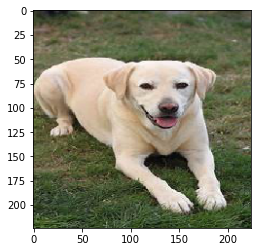

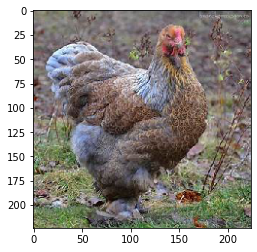

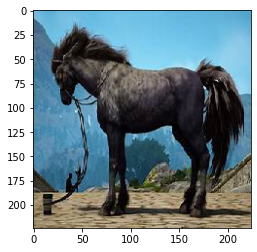

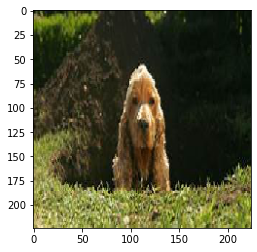

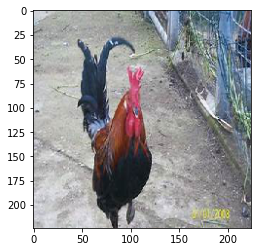

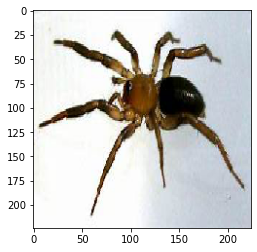

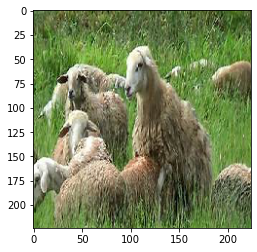

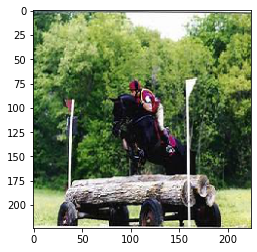

In [21]:
plot_batch(val_batch,val_lables)

## vgg16

In [22]:
input_shape = (IMAGE_HEIGHT,IMAGE_WIDTH,3)
conv_base = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")

In [23]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [24]:
from tensorflow.keras.layers import GlobalMaxPooling2D,Dense,Dropout
from tensorflow.keras.models import Model

def get_vgg16(input_shape=(224,224,3),froze_layer_index=20):
    conv_base = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
    
    for layer in conv_base.layers[:froze_layer_index]:
        layer.trainable = False

    for layer in conv_base.layers[froze_layer_index:]:
        layer.trainable = True
    
    last_output = conv_base.layers[-1].output

    x = GlobalMaxPooling2D()(last_output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(10, activation='softmax')(x)

    model = Model(conv_base.input, x)

    return model

In [25]:
from tensorflow.keras.backend import clear_session
clear_session()

In [27]:
model = get_vgg16(froze_layer_index=20)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [28]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10)
lr_scheduler = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.1, 
                                            min_lr=0.00001)

callbacks = [earlystop, lr_scheduler]


In [29]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
history = model.fit_generator(
    train_generator, 
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=val_DF.shape[0]//VAL_BATCH_SIZE,
    steps_per_epoch=train_DF.shape[0]//TRAIN_BATCH_SIZE,
    callbacks=callbacks
)

Epoch 1/10
   1/1227 [..............................] - ETA: 15:13:09 - loss: 3.1512 - accuracy: 0.0625

In [ ]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
    ax1.plot(history.history['loss'], color='b', label="Training loss")
    ax1.plot(history.history['val_loss'], color='r', label="validation loss")
    ax1.set_xticks(np.arange(1, EPOCHS, 1))
    ax1.set_yticks(np.arange(0, 1, 0.1))

    ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
    ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
    ax2.set_xticks(np.arange(1, EPOCHS, 1))

    legend = plt.legend(loc='best', shadow=True)
    plt.tight_layout()
    plt.show()